<a href="https://colab.research.google.com/github/makezazainw/FinalProject/blob/master/Show%20Lab-Original%20Model-VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Kaggle**

In [1]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 5.3MB 7.9MB/s 
     |████████████████████████████████| 112kB 56.8MB/s 
     |████████████████████████████████| 143kB 56.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


**Call file from Json for use Kaggle Dataset**



In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "thammatattantipitham" 
os.environ['KAGGLE_KEY'] = "3cf826ab97707228fb1602519992740b"

In [3]:
!kaggle datasets download -d thammatattantipitham/originalthaiherb --unzip

 60% 9.00M/15.0M [00:00<00:00, 20.5MB/s]
100% 15.0M/15.0M [00:00<00:00, 30.5MB/s]


**Move to Directory thai-herb**

In [4]:
!mkdir originalthaiherb
!mv  "train" "val" originalthaiherb

**Start**

In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import keras

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.applications import InceptionV3
sys.version

'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [6]:
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
DATASET_PATH  = 'originalthaiherb/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 10
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
epochs    = 200

In [8]:
#ทำ aug มาเเล้ว
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
#set training data
train_generator = train_datagen.flow_from_directory(DATASET_PATH+ r"train/",
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset='training')

Found 1600 images belonging to 10 classes.


In [10]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH+ r"val/",                                      
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = 1,
                                                    class_mode='categorical',
                                                    shuffle = True
                                                    )

Found 410 images belonging to 10 classes.


**How to use the checkpoint from google drive**

In [ ]:
!mkdir training_ResNet50
!unzip "/content/drive/My Drive/Final Project/Dataset-Lab/Original/training/training.zip" "/content/training_ResNet50"

**ResNet50**

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_ResNet50/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=50)

#Create the model
base_model_resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
#Defining and Adding layers
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'),input_dim=64))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(NUM_CLASSES,activation=('softmax'))) #This is the classification layer


# Save the weights using the `checkpoint_path` format
model_resnet.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
train_generator.class_indices

{'eilerd': 0,
 'fahthalinejol': 1,
 'horapa': 2,
 'krapao': 3,
 'lemon': 4,
 'magrud': 5,
 'plu': 6,
 'sabtiger': 7,
 'saranae': 8,
 'yanang': 9}

In [ ]:
#Model summary
model_resnet.summary()

In [ ]:
model_resnet.compile(optimizer=Adam(lr=0.0001),  #Adam(lr=1e-5)
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#start to train the model
start = time.time()
history = model_resnet.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.samples//BATCH_SIZE, validation_data=valid_generator,validation_steps=valid_generator.samples,callbacks=[cp_callback],verbose=1)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

**VGG19**

In [25]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_VGG19/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=50)

#Create the model
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_tensor=None, input_shape = (224, 224, 3))
    
    #5 layers เเรก จะไม่ถูกฝึกเนื่องจากใช้วิธีการ freeze ไว้เเล้ว
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #ทำการเพิ่ม layers ที่กำหนดขึ้นมาเอง เป็นการปรับเเต่งเพื่อเพิ่มประสิทธิภาพ 
    x = model.output
    x = Flatten()(x)
#     x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(NUM_CLASSES, activation="softmax")(x)
    
    #สร้าง model ชั้นสุดท้ายเพื่อจะนำมา compile
    model_VGG19 = Model(inputs = model.input, outputs = predictions)
    
    model_VGG19.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy']) # optimizer=RMSprop(lr=0.001)

    return model_VGG19

    # Save the weights using the `checkpoint_path` format
    model_VGG19.save_weights(checkpoint_path.format(epoch=0))

In [26]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [30]:
start = time.time()

history = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs, 
    validation_steps=valid_generator.samples//BATCH_SIZE, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=valid_generator,
    callbacks = [cp_callback],
    verbose = 1
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/200
50/50 [==============================] - 24s 486ms/step - loss: 2.3810 - accuracy: 0.1719 - val_loss: 2.0148 - val_accuracy: 0.0833
Epoch 2/200
50/50 [==============================] - 24s 484ms/step - loss: 1.5732 - accuracy: 0.4175 - val_loss: 0.8738 - val_accuracy: 0.6667
Epoch 3/200
50/50 [==============================] - 24s 477ms/step - loss: 1.1797 - accuracy: 0.5738 - val_loss: 0.8573 - val_accuracy: 0.5833
Epoch 4/200
50/50 [==============================] - 24s 479ms/step - loss: 0.6287 - accuracy: 0.7731 - val_loss: 0.5962 - val_accuracy: 0.7500
Epoch 5/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5617 - accuracy: 0.8100 - val_loss: 0.2325 - val_accuracy: 0.9167
Epoch 6/200
50/50 [==============================] - 24s 482ms/step - loss: 0.4362 - accuracy: 0.8575 - val_loss: 0.3474 - val_accuracy: 0.9167
Epoch 7/200
50/50 [==============================] - 24s 480ms/step - loss: 0.2537 - accuracy: 0.9125 - val_loss: 0.0697 - val_accuracy:

**Make Zipfile to training for saving in google drive**

In [ ]:
!zip -r "/content/drive/My Drive/Final Project/Dataset-Lab/Original/training/training.zip" "training_2"

  adding: training_2/ (stored 0%)
  adding: training_2/cp-0002.ckpt.index (deflated 82%)
  adding: training_2/cp-0004.ckpt.index (deflated 82%)
  adding: training_2/cp-0050.ckpt.data-00000-of-00001 (deflated 12%)
  adding: training_2/cp-0100.ckpt.index (deflated 82%)
  adding: training_2/cp-0000.ckpt.data-00000-of-00001 (deflated 9%)
  adding: training_2/cp-0004.ckpt.data-00000-of-00001 (deflated 23%)
  adding: training_2/cp-0100.ckpt.data-00000-of-00001 (deflated 12%)
  adding: training_2/cp-0000.ckpt.index (deflated 82%)
  adding: training_2/cp-0150.ckpt.data-00000-of-00001 (deflated 13%)
  adding: training_2/checkpoint (deflated 40%)
  adding: training_2/cp-0050.ckpt.index (deflated 82%)
  adding: training_2/cp-0150.ckpt.index (deflated 82%)
  adding: training_2/cp-0002.ckpt.data-00000-of-00001 (deflated 23%)


**Save model file .h5 ResNet50, VGG19, MobileNet**

In [ ]:
!mkdir save_model
model_resnet.save('save_model/model-resnet50(200epochs).h5') #ดูจำนวนรอบที่เทรนด้วยว่าทั้งหมดกี่รอบจริงๆเเล้ว

In [33]:
!mkdir save_model
model_VGG19.save('save_model/model-VGG19(200epochs).h5') #ดูจำนวนรอบที่เทรนด้วยว่าทั้งหมดกี่รอบจริงๆเเล้ว

**Save file json**

In [ ]:
#Import dependencies
!mkdir jsonfile
import json
from keras.models import model_from_json, load_model
with open('jsonfile/model_resnet.json', 'w') as f:
    f.write(model.to_json())
print("Saved model to disk")


**Show graphs ResNet50**

In [ ]:
#กราฟเเม่นยำเเละ loss
import matplotlib.pyplot as plt

acc = model_resnet.history.history['accuracy']
val_acc = model_resnet.history.history['val_accuracy']

loss= model_resnet.history.history['loss']
val_loss= model_resnet.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()
# plt.savefig('accandloss.png')


**Show graphs VGG19**

In [ ]:
#กราฟเเม่นยำเเละ loss
import matplotlib.pyplot as plt

acc = model_VGG19.history.history['accuracy']
val_acc = model_VGG19.history.history['val_accuracy']

loss= model_VGG19.history.history['loss']
val_loss= model_VGG19.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()
# plt.savefig('accandloss.png')

**Check the checkpoints of model**

In [35]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_VGG19/cp-0200.ckpt'

In [ ]:
# Load the previously saved weights
model_resnet.load_weights(latest)

# Re-evaluate the model
loss, acc = model_resnet.evaluate(x,y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [40]:
# Load the previously saved weights
model_VGG19.load_weights(latest)

# Re-evaluate the model
loss, acc = model_VGG19.evaluate(x,y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1/1 - 0s - loss: 2.3025 - accuracy: 0.0000e+00
Restored model, accuracy:  0.00%


In [39]:
#สำหรับเช็คค่าของการเทส
x,y = valid_generator.next()
x.shape
y.shape

(1, 10)

**Save the model**

In [ ]:
# Save the entire model as a SavedModel.
model_resnet.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
!ls saved_model/my_model

assets	saved_model.pb	variables


**Convert file model .pb to tflite**

In [ ]:
model= tf.keras.models.load_model('saved_model/my_model')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model) 

INFO:tensorflow:Assets written to: /tmp/tmpwzetbf5g/assets


507786404

In [ ]:
!mv "tf_lite_model.tflite" "/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/tflite"
print("Success")

Success


**Prediction**

In [ ]:
categories =  ['eilerd', 'fahthalinejol', 'horapa', 'krapao', 'lemon', 'magrud', 'plu', 'sabtiger', 'saranae', 'yanang']

In [ ]:
model = model_resnet.load_weights('save_model/model-resnet50(200epochs).h5')

In [ ]:
loss, acc = model.evaluate(valid_generator, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

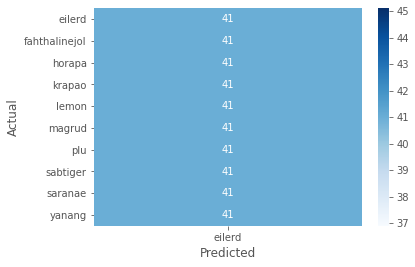

test accuracy : 10.0


In [34]:
import seaborn as sn
import pandas as pd

model = tf.keras.models.load_model('save_model/model-VGG19(200epochs).h5')
filenames = valid_generator.filenames
nb_samples = len(valid_generator)
y_prob=[]
y_act=[]
valid_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = valid_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)
    
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot= True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

**เพิ่มเติมโอนย้ายไฟล์หลังจากเสร็จเเล้ว**

In [ ]:
!mv "save_model/model-resnet50(200epochs).h5" "/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model"